In [1]:
import os
import numpy as np
import pandas as pd
from datetime import datetime, timedelta


import xarray as xr
import matplotlib.pyplot as plt
import sys
sys.path.append(r'C:\Users\ruro\OneDrive - Boskalis\Documents\python\OSSI')
from KNMI_readers import read_knmi_uurgeg


import puv


In [2]:
def ossi_data_reader(datafolder):
    '''
    author: Paul van Wiechen

    Function to read all WLOG_XXX files in a certain subfolder.
    Make sure that only WLOG_XXX files are in this folder and no other files.
    Only WLOG_XXX files with minimally 2 rows are appended to the dataframe.
    A correct WLOG_XXX file should contain a first line with OSSI configuration, and a second line (third row) with starting time
    Timestep and sampling frequency are retrieved from the first row. Starting time from the next row
    Returns a dataframe with a time column and pressure column in dbars
    '''

    ossi = pd.DataFrame({
        't': [],
        'p': []})

    directory = str(datafolder)

    for filename in os.listdir(directory):
        f = os.path.join(directory, filename)

        # checking if it is a file
        if os.path.isfile(f):
            print('Currently concatenating file ' + f)
            ossi_raw = pd.read_csv(f, header=None, nrows=4, sep=',')
            if len(ossi_raw.index) > 2:
                t_0 = datetime(int(str(20) + ossi_raw[0][1][1:]), int(ossi_raw[1][1][1:]), int(ossi_raw[2][1][1:]),
                               int(ossi_raw[3][1][1:]), int(ossi_raw[4][1][1:]), int(ossi_raw[5][1][1:]))
                dt = 1 / float(ossi_raw[6][0][1:])
                ossi_tot = pd.read_csv(f, skiprows=3, usecols=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], header=None,
                                       sep=',', skipinitialspace=True).to_numpy().flatten()
                ossi_temp = pd.DataFrame({
                    't': np.array([t_0 + timedelta(seconds=dt * i) for i in range(len(ossi_tot))]),
                    'p': ossi_tot})

                ossi_temp.dropna(inplace=True)
                ossi_temp['p'] = ossi_temp['p'] * 1e5  # Bar to Pa

                ossi = pd.concat([ossi, ossi_temp], ignore_index=True)

    ossi['p'] = pd.to_numeric(ossi['p'])
    ossi['t'] = pd.to_datetime(ossi['t'])

    return ossi.set_index('t')

In [3]:
experimentFolder = r"C:\Users\ruro\OneDrive - Boskalis\Documents\python\01-Fieldwork\Pressure_sensors\OSSI\OSSI_01_data"    #Grand map
dfp = ossi_data_reader(os.path.join(experimentFolder,'Ossi01_25-27'))                                                       #specific map for data OSSI

instrument = 'OSSI_01'          # Specific name instrument
sf = 10                          # Hz, sampling frequency
xRD = 117221.8                   # location x-coord
yRD = 559793.1                   # location y-coord
serial_number = '18.09.00.08'    # unique serial number

rho = 1028      # Density of sea water
g = 9.81        # Gravitational force
zb = -1.43      # Height of sea bed
zi = -1.30      # Height of instrument

knmiFile = r"C:\Users\ruro\OneDrive - Boskalis\Documents\python\01-Fieldwork\uurgeg_330_2021-2030.txt"

ds = dfp.to_xarray()
ds['p'] = ds.p.astype('int32')
ds.p.attrs = {'long_name': 'pressure', 'units': 'Pa'}

# add global attribute metadata
ds.attrs = {
    'Conventions': 'CF-1.6',
    'name': '{}'.format(instrument),
    'instrument': '{}'.format(instrument),
    'instrument type': 'OSSI',
    'instrument serial number': '{}'.format(serial_number),
    'epsg': 28992,
    'x': xRD,
    'y': yRD,
    'sf': 10,
    'time zone': 'UTC+2',
    'summary': 'SEDMEX field campaign',
    'contact person': 'Marlies van der Lugt',
    'emailadres': 'm.a.vanderlugt@tudelft.nl',
    'construction datetime': datetime.now().strftime("%d-%b-%Y (%H:%M:%S)"),
    'version': 'v1',
    'version comments': 'constructed with xarray'}

#if nothing else, at least specify lossless zlib compression
comp = dict(zlib=True, complevel=5)
ds.encoding = {var: comp for var in ds.data_vars}

# save to file
if not os.path.isdir(os.path.join(experimentFolder,'raw_netcdf')):
    os.mkdir(os.path.join(experimentFolder,'raw_netcdf'))
ncFilePath = os.path.join(experimentFolder, 'raw_netcdf', instrument + '.nc')
ds.to_netcdf(ncFilePath)


Currently concatenating file C:\Users\ruro\OneDrive - Boskalis\Documents\python\01-Fieldwork\Pressure_sensors\OSSI\OSSI_01_data\Ossi01_25-27\WLOG_001.CSV
Currently concatenating file C:\Users\ruro\OneDrive - Boskalis\Documents\python\01-Fieldwork\Pressure_sensors\OSSI\OSSI_01_data\Ossi01_25-27\WLOG_002.CSV


C:\Users\ruro\AppData\Local\Temp\ipykernel_26104\2310083709.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ossi = pd.concat([ossi, ossi_temp], ignore_index=True)


Currently concatenating file C:\Users\ruro\OneDrive - Boskalis\Documents\python\01-Fieldwork\Pressure_sensors\OSSI\OSSI_01_data\Ossi01_25-27\WLOG_003.CSV
Currently concatenating file C:\Users\ruro\OneDrive - Boskalis\Documents\python\01-Fieldwork\Pressure_sensors\OSSI\OSSI_01_data\Ossi01_25-27\WLOG_004.CSV


In [4]:
ds

<xarray.Dataset> Size: 49MB
Dimensions:  (t: 4052936)
Coordinates:
  * t        (t) datetime64[ns] 32MB 2024-09-25T12:31:00 ... 2024-09-27T20:50...
Data variables:
    p        (t) int32 16MB 15308 15308 15323 15307 ... 15171 15171 15171 15171
Attributes: (12/16)
    Conventions:               CF-1.6
    name:                      OSSI_01
    instrument:                OSSI_01
    instrument type:           OSSI
    instrument serial number:  18.09.00.08
    epsg:                      28992
    ...                        ...
    summary:                   SEDMEX field campaign
    contact person:            Marlies van der Lugt
    emailadres:                m.a.vanderlugt@tudelft.nl
    construction datetime:     11-Nov-2024 (12:21:39)
    version:                   v1
    version comments:          constructed with xarray

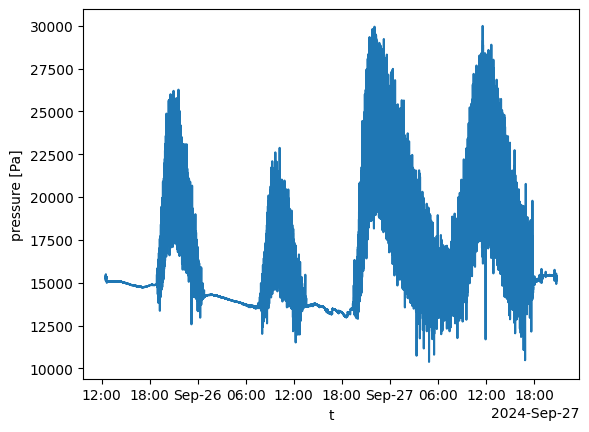

In [5]:
ds.p.plot()